**In this note book we will performe the multi label text classification for the BBC news on the different news categories based on  politics ,sports, business, techand entertainement.
This Notebook would Involve the concepts around NLP and RNN along with LSTM.**


<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li>Load the BBC data</li>
        <li>Data Analysis</li>
        <li>Convert News data to Numerical format</li>
        <li>Create Train and Test data</li>
        <li>Model1: Create a Base model with Simple RNN</li>
        <li>Model2: Create a hyper parameter tuned Model with Biderctional RNN & LSTM using Keras Tuner </li>
        <li>Results</li>
    </ol>
</div>
<br>
<hr>

#### Import the Libraries
we will be working with the below libaries in this project:
<ul>
<li>tensorflow</li>
<li>keras</li>
<li>keras tuner</li>
<li>nltk</li>
<li>gensim</li>
</ul>

In [1]:
import tensorflow as tf
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
import pandas as pd
from nltk.stem import WordNetLemmatizer
import re
import nltk
import pandas as pd
from kerastuner.tuners import RandomSearch
from tensorflow.keras.metrics import Precision
import kerastuner




#### Load the data from the CSV

In [2]:
df=pd.read_csv('bbc-text.csv')
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


#### Creating Base Parameters for NLP and RNN architecture.


In [3]:
vocab_size = 5000
embedding_dim = 32
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

#### seeing different categories of news

In [4]:
df['category'].unique()

array(['tech', 'business', 'sport', 'entertainment', 'politics'],
      dtype=object)

**we are going to preprocess the data i.e we will be:<br>**
**1.)removing any regular expression.<br>**
**3.)Performe Lemmitization.<br>**
**2.)removing the stop words from the data.<br>**

In [5]:
corpus=[]
lem =WordNetLemmatizer()
for i in range(len(df)):
    sent=re.sub('[^a-zA-Z]', ' ',df.text[i])
    sent=sent.lower()
    sent=nltk.word_tokenize(sent)
    sent=[lem.lemmatize(word) for word in sent if  word  not in stopwords.words('english')]
    sent=' '.join(sent)
    corpus.append(sent)


#### After Cleaning the data , we are creating another column called as clean_text.

In [6]:
df['clean_text']=corpus
df.head()

,category,text,clean_text
0,tech,tv future in the hands of viewers with home th...,tv future hand viewer home theatre system plas...
1,business,worldcom boss left books alone former worldc...,worldcom bos left book alone former worldcom b...
2,sport,tigers wary of farrell gamble leicester say ...,tiger wary farrell gamble leicester say rushed...
3,sport,yeading face newcastle in fa cup premiership s...,yeading face newcastle fa cup premiership side...
4,entertainment,ocean s twelve raids box office ocean s twelve...,ocean twelve raid box office ocean twelve crim...


**Convert the Clean-Text into Vectors using Keras Onehot**
The clean-text is in the text format , we need to convert it into numerical format or the vector format.
One-hot encodes a text into a list of word indexes of size n.
This function receives as input a string of text and returns a list of encoded integers each corresponding to a word (or token) in the given input string.

In [7]:
from tensorflow.keras.preprocessing.text import one_hot
onehot_repr=[one_hot(words,vocab_size)for words in df['clean_text'].values] 


#### Padding the Vectors:
We are padding the input sequences so that they are aligned together.
Padding can be a pre or a post, we are doing the post padding here, so if the given input sequence is less than the max_length we will pad the rest of places with 0.

In [8]:
embedded_docs=pad_sequences(onehot_repr,maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(embedded_docs)

[[3167 1856 3165 ... 2734 2090 1388]
 [1953 2387 4920 ...    0    0    0]
 [1352 1422 3358 ...    0    0    0]
 ...
 [3776 2971 2271 ...    0    0    0]
 [4707 2045 2609 ... 4505  196 4860]
 [ 273 3592 3372 ...    0    0    0]]


In [9]:
X_data =np.array(embedded_docs)


#### Create Y labels:
Here we create labels for our target variable , since we have 5 different news category we will create 5 labels.

In [10]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(df.category)
Y_data=np.array(label_tokenizer.texts_to_sequences(df.category))


#### Separate Train,Test and Validation data

In [11]:
bbc_data = X_data[:1800]
bbc_data_test=X_data[1800:]
bbc_label =Y_data[:1800]
bbc_label_test =Y_data[1800:]

In [12]:
from sklearn.model_selection import train_test_split
BBC_train_X, BBC_val_X, BBC_train_y, BBC_val_y=train_test_split(bbc_data,bbc_label ,test_size = 0.20, random_state = 0)



In [13]:
print(BBC_train_X.shape)
print(BBC_val_X.shape)
print(bbc_data_test.shape)

(1440, 200)
(360, 200)
(425, 200)


So we have <b>1440</b> train data , <b>360</b> val data and <b>425</b> test data

**Create a count Plot for the labels**<br>
Looking at the count plot for all the 5 categories the dataset doesnot looks to be an imbalanced dataset.

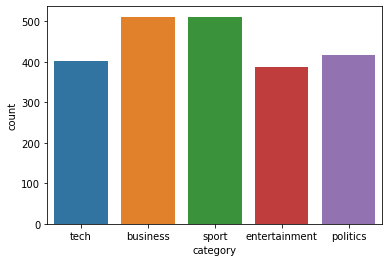

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.countplot(data=df,x=df.category)

**Lets Create an multiple Keras Model using the below** **Techniques:**

**1.)In the First Model We will Create a Keras Model using Simple RNN.**

**2.)In the Second Model We will hypertune a Keras Model using Bidirectional RNN and BILSTM.**

**In Both the models we will use Keras Embedding layer to convert the Tokens in dense vectors of 64 dimensions.**


## Simple RNN

In [15]:
def build_model():
    model =tf.keras.Sequential([
            tf.keras.layers.Embedding(vocab_size,embedding_dim),
            tf.keras.layers.SimpleRNN(20),
            tf.keras.layers.Dense(embedding_dim, activation='relu'),
            tf.keras.layers.Dense(6, activation='softmax')      
    ])

    model.summary()
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
    return model

In [16]:
model = build_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          160000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 20)                1060      
_________________________________________________________________
dense (Dense)                (None, 32)                672       
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 161,930
Trainable params: 161,930
Non-trainable params: 0
_________________________________________________________________


In [17]:
history= model.fit(BBC_train_X,BBC_train_y,epochs=4,validation_data=(BBC_val_X,BBC_val_y))

Epoch 1/4
45/45 [==============================] - 3s 58ms/step - loss: 1.6554 - val_loss: 1.6008
Epoch 2/4
45/45 [==============================] - 2s 48ms/step - loss: 1.5310 - val_loss: 1.5559
Epoch 3/4
45/45 [==============================] - 2s 49ms/step - loss: 1.3307 - val_loss: 1.4842
Epoch 4/4
45/45 [==============================] - 2s 49ms/step - loss: 1.1210 - val_loss: 1.4804


In [18]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


#### Plot Loss VS Validation Loss

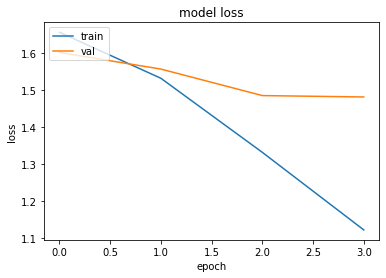

In [19]:
## summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
y_prd= model.predict(bbc_data_test).argmax(axis=1)


#### Using Classification report to see the Precision value for the different labels

In [21]:
from sklearn.metrics import classification_report
print(classification_report(bbc_label_test,y_prd))

              precision    recall  f1-score   support

           1       0.53      0.08      0.14        97
           2       0.32      0.73      0.45       103
           3       0.45      0.33      0.38        82
           4       0.42      0.48      0.45        83
           5       0.14      0.05      0.07        60

    accuracy                           0.36       425
   macro avg       0.37      0.33      0.30       425
weighted avg       0.39      0.36      0.31       425



## Bidirectional RNN with LSTM using Keras Tuner
We will performe hyperparameter tuning of the Birectional RNN & LSTM with the help of keras tuner.<br>
Some of the Parameter that we will tune are: <br>
- Embedding Layer
- LSTM Layer
- Hidden layers


In [32]:
def hyp_build_model(hp):
    Embedding_units=hp.Int('units',min_value=32,max_value=100,step=5)
    model =tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(vocab_size,Embedding_units)),
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(Embedding_units))),
    for i in range(0,4):
        model.add(tf.keras.layers.Dense(Embedding_units, activation='relu')),
        model.add(tf.keras.layers.Dropout(0.2,input_shape=(vocab_size,))),
    model.add(tf.keras.layers.Dense(6,activation='softmax'))
    model.summary()
    model.compile(loss='sparse_categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4])))
    return model


#### Create a Keras Tuner Random search space
- max_trail =3
- execution per trail =3

In [33]:
tuner = RandomSearch(
    hyp_build_model,
    objective= kerastuner.Objective('val_loss',direction='min'),
    max_trials=3,
    executions_per_trial=3,
    directory='my_dir_precision_14',
    project_name='bbcclassifier')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                16640     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1

In [34]:
tuner.search(x= BBC_train_X, y=BBC_train_y,epochs=4,batch_size=64,validation_data=(BBC_val_X,BBC_val_y))

Trial 3 Complete [00h 01m 32s]
val_loss: 0.9106221993764242

Best val_loss So Far: 0.7540885408719381
Total elapsed time: 00h 07m 24s
INFO:tensorflow:Oracle triggered exit


#### Get best 10 result by the keras tuner

In [35]:
tuner.results_summary()


Results summary
Results in my_dir_precision_14\bbcclassifier
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 77
learning_rate: 0.001
Score: 0.7540885408719381
Trial summary
Hyperparameters:
units: 67
learning_rate: 0.01
Score: 0.7986388007799784
Trial summary
Hyperparameters:
units: 37
learning_rate: 0.01
Score: 0.9106221993764242


In [36]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 77 and the optimal learning rate for the optimizer
is 0.001.



Create the model with the best hyperparameter generated by the tuner

In [37]:
hyp_model = tuner.hypermodel.build(best_hps)
history_hyp=hyp_model.fit(BBC_train_X,BBC_train_y,epochs=4,validation_data=(BBC_val_X,BBC_val_y))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 77)          385000    
_________________________________________________________________
bidirectional (Bidirectional (None, 154)               95480     
_________________________________________________________________
dense (Dense)                (None, 77)                11935     
_________________________________________________________________
dropout (Dropout)            (None, 77)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 77)                6006      
_________________________________________________________________
dropout_1 (Dropout)          (None, 77)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 77)                6

In [38]:
print(history_hyp.history.keys())

dict_keys(['loss', 'val_loss'])


#### Plot Loss VS Validation Loss

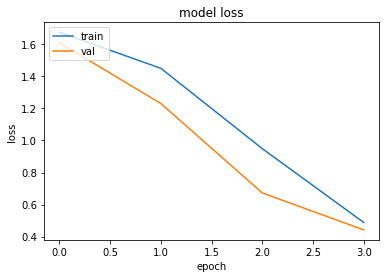

In [39]:
plt.plot(history_hyp.history['loss'])
plt.plot(history_hyp.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [40]:
y_pred_hyp = hyp_model.predict(bbc_data_test).argmax(axis=1)

#### Using Classification report to see the Precision value for the different labels

In [41]:
print(classification_report(bbc_label_test,y_pred_hyp))

              precision    recall  f1-score   support

           1       0.93      0.92      0.92        97
           2       0.88      0.92      0.90       103
           3       0.71      0.82      0.76        82
           4       0.89      0.71      0.79        83
           5       0.89      0.90      0.89        60

    accuracy                           0.86       425
   macro avg       0.86      0.85      0.85       425
weighted avg       0.86      0.86      0.86       425



## Result Observed:
As we can see the model which was developed using keras tuner using Bidirectional RNN and LSTM performed in a much better way as compared to the the baseline model which was developed using Simple RNN.The precision value of the Model 2 was much better than Model 1.
